# <center>Toxic Comment Classification</center>

## Introduction
<br/>
<div style="text-align: justify">The aim of this project is to develop a machine learning model that can detect toxic comments and correctly identify different types of toxicity, such as hate speech, threats and obscenity. Creating a toxic comment classifier that can effectively handle nuanced and contextual language will be a crucial step towards the development of more automated content moderation systems. Such systems can keep up with the unceasing stream of user-generated online content and thus alleviate the burden on human moderators. Therefore, greater automation of current moderation systems has the potential to offer online users much greater protection from harmful material.
<br>
    
In this notebook, I will explore the Toxic Comment Classification dataset from Kaggle.</div>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras.models import load_model

/Users/thawana/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.



## Data pre-processing

In [2]:
os.chdir('/Users/thawana/Desktop/toxic')

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Checking for missing comments
a = sum(train['comment_text'].isnull())
print('No. of missing comments: {}'.format(a) )

No. of missing comments: 0


To process the text in the `comment_text` column, we will begin by removing all non-letter characters (such as punctuation marks and HTML tags) and stopwords (high frequency words that are unlikely to add much meaning to the sentence). Then, we will use the spaCy library to generate the root form (lemma) of each word. Because spaCy lemmatises words according to their part-of-speech tag, it is able to generate more accurate lemmas. Finally, we will create a bag-of-words representation of the cleaned text.

In [91]:
# Place the nltk stopwords in a set and initialize spacy 'en' model
stop_words = set(stopwords.words("english"))  
nlp = spacy.load('en', disable=['parser', 'ner']) 

def text_processor(text):
    '''
    This function removes stopwords and words longer than 19 characters from a given string. 
    The resulting string is tokenised and each token then lemmatised.
    '''
    tokens = word_tokenize(text)
    no_stopwords = [w.lower() for w in tokens if not w in stop_words and len(w)<20]
    sentence = nlp(" ".join(no_stopwords))   
    return " ".join([token.lemma_ for token in sentence])

def bag_of_words(clean_text, m, n):
    '''
    This function returns a bag-of-words model and the entire vocabulary for a given list of strings.
    '''
    vectorizer = CountVectorizer(ngram_range=(m, n), analyzer = "word", tokenizer = None, preprocessor = None)
    bow = vectorizer.fit_transform(clean_text)
    words = vectorizer.get_feature_names()
    return bow, words

def dataset_processor(dataset):
    '''
    This function will remove non-letter characters from a list of strings, feed the strings first into the 
    text_processor function and then into the bag_of_words model.
    '''
    dataset['comments_clean'] = dataset['comment_text'].str.replace("[^a-zA-Z]", " ") 
    dataset['comments_clean'] = dataset['comments_clean'].apply(text_processor)
    dataset['comments_clean'] = dataset['comments_clean'].fillna('blank')
    bow, words = bag_of_words(dataset['comments_clean'], 1, 1)
    return bow, words

train_bow, train_words = dataset_processor(train)
sparse.save_npz("train_bow.npz", train_bow)

In [90]:
# Will also create two bag-of-Ngrams models
train_ngram, train_ngram_vocab = bag_of_words(train['comments_clean'], 1, 2) # looks at single words and bigrams
train_bigram, train_bigram_vocab = bag_of_words(train['comments_clean'], 2, 2) # looks at bigrams only

## Exploratory data analysis

Now that the text is cleaned, we can perform some exploratory data analysis. First we will plot wordclouds to show the most frequently occuring words in each category of comment.

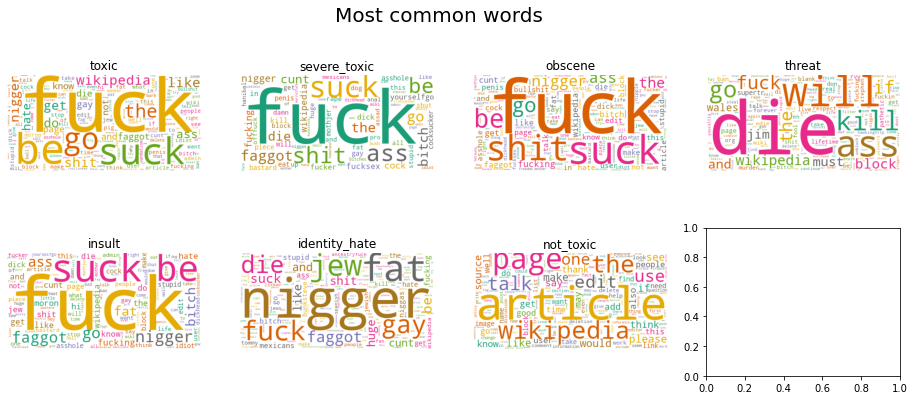

In [92]:
# Create a 'not_toxic' column for comments that have not been assigned any of the toxic categories
columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train['not_toxic'] = train[columns].sum(1) == 0    
train['not_toxic'] = train['not_toxic'].astype(int)
columns.append('not_toxic')

# Create a wordcloud object
wc = WordCloud(background_color="white", 
                   colormap="Dark2",
                   max_font_size=150, 
                   random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]

def wordcloud_plot(data, vocab, title):
    '''
    For each category of comment, this function will find the top 1000 most occuring words in that category and 
    use them to plot a word cloud.
    '''
    fig, ax = plt.subplots(nrows=2, ncols=4)
    counter = 0
    for counter in range(7):
        column = columns[counter]
        totals = np.asarray(data[train[column]==1].sum(0)).reshape(-1)
        totals_df = pd.Series(data=totals,index=vocab)
        top_words = totals_df.sort_values(ascending = False)[:1000].drop('pron').to_dict()  
        wc.generate_from_frequencies(top_words)
        counter +=1
        plt.subplot(2,4,counter).set_title(column)
        plt.plot()
        plt.imshow(wc)
        plt.axis('off')   
    fig.suptitle(title, size = 20)
    plt.show()

wordcloud_plot(train_bow, train_words, 'Most common words')

My observations:
- The language used in 'toxic', 'severe_toxic', 'obscene' and 'insulting' comments appears to be very similar. 
- The langugage in 'threat' and 'identity_hate' categories is very distinct from the other toxic categories. 
- Comments classed as 'not_toxic' contain very little bad language.

If the language used in 'toxic', 'severe_toxic', 'obscene' and 'insult' comments is very similar then differences between these comments may lie in the number of times these words are used in a single comment or the context in which they are used. To see if there are differences in context, I have plotted wordclouds for the most common <b>bigrams</b> (see below)

Note that 'pron' is actually the most common word in nearly all categories but it simply stand for pronoun - when spaCy performs lemmatisation, it shortens all pronouns such as 'you', 'he', 'they' to -PRON-. Therefore, when creating the wordclouds, I decided to drop this word.

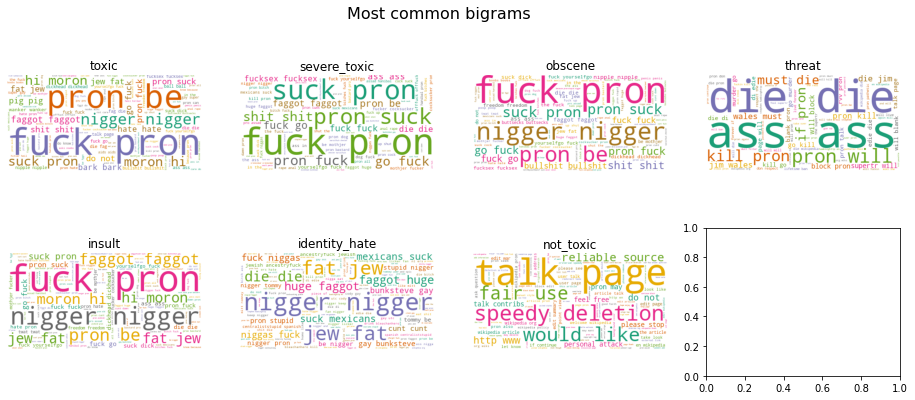

In [199]:
wordcloud_plot(train_bigram, train_bigram_vocab, 'Most common bigrams')

Similar to the wordclouds showing the most common words, these bigram wordclouds reveal very few differences between the language in toxic, severe_toxic, obscene and insulting comments. On the other hand, the language of threat, identity_hate and not_toxic comments is more distinct.

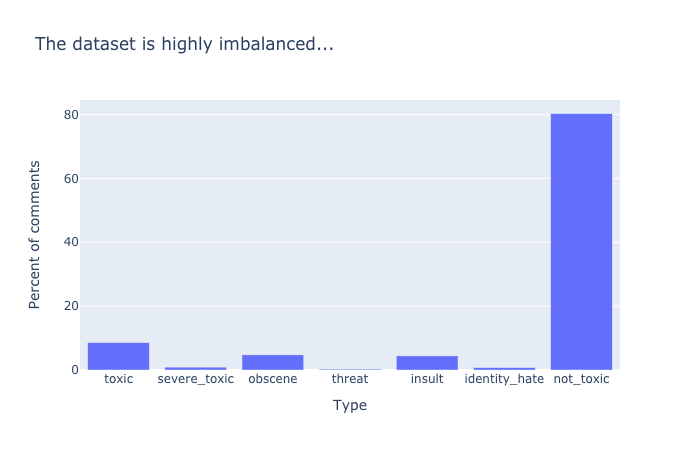

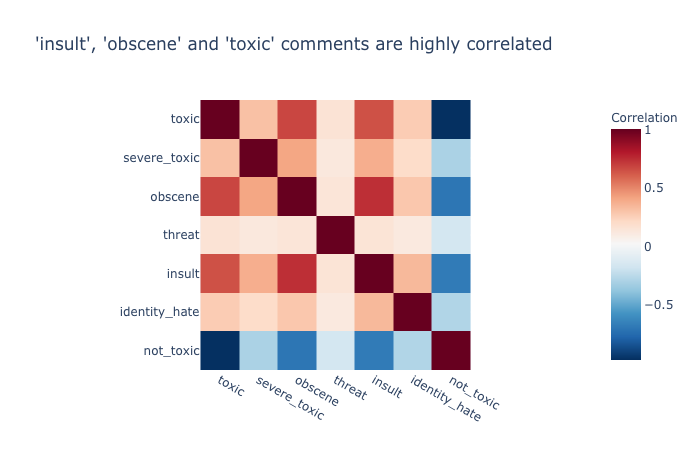

In [12]:
plt.rcParams['figure.figsize'] = [10, 6]

# Calculate percentage of dataset that each category makes up and plot as bar chart
total = pd.DataFrame(train[columns].sum(0),columns=['Number of comments'])
total['Number of comments'] = round(100*total['Number of comments']/int(total.sum()),2)

# Calculate correlations between the different categories
correlation = train.iloc[:,2:9].corr()

fig = px.bar(total, x=total.index,y='Number of comments',
             labels = {'index':'Type',
                       'Number of comments':'Percent of comments'},
             title = 'The dataset is highly imbalanced...')
fig.show(renderer = 'png')   # will display a static image (not interactive)
fig = px.imshow(correlation,color_continuous_scale='RdBu_r',
                labels = {'color':'Correlation'},
                title="'insult', 'obscene' and 'toxic' comments are highly correlated")
fig.show(renderer = 'png')


#total.plot.bar(title='The dataset is highly imbalanced...')

From the bar chart it can be seen that most comments are 'not_toxic' whilst the 'severe_toxic', 'threat' and 'identity_hate' comments cumulatively make up less than 2 % of the dataset. Since these are arguably the most serious kind of toxic comments, it will be important to try and address this class imbalance.

In [12]:
#sns.heatmap(correlation,cmap='RdBu_r')

This heatmap shows that comments can have more than one label, making this a multi-label problem, and it confirms what we saw with the wordclouds; because 'toxic', 'obsence' and 'insult' comments share many words, they are highly correlated. This means, for instance, that a comment labelled 'toxic', is likely to also be labelled 'obscene' and 'insult' as well. Interestingly however, contrary to what the wordclouds suggest, the correlation between these three categories and 'severe_toxic' comments is, although present, weaker.

## Random Forest and Logistic Regression models

In this section, we will train random forest and logistic regression models on our bag-of-words representation.

In [ ]:
# Split bag-of-words and bag-of-Ngram models (words + bigrams) into train and test dataset

test_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(train_bow, train[test_cols], 
                                                                    test_size=0.25, random_state=42)

X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(train_ngram, train[test_cols], 
                                                                    test_size=0.25, random_state=42)

We will create a baseline model which we will compare all other models to. For the baseline, we will simply predict that all comments are 'not_toxic'.

In [8]:
train[test_cols].shape

(159571, 6)

In [88]:
# Baseline model 1 - always predict 0
for category in test_cols:
    score = roc_auc_score(train[category], np.zeros(159571))
    print('{} ROC AUC score: {}'.format(category,score))

toxic ROC AUC score: 0.5
severe_toxic ROC AUC score: 0.5
obscene ROC AUC score: 0.5
threat ROC AUC score: 0.5
insult ROC AUC score: 0.5
identity_hate ROC AUC score: 0.5


In [89]:
# Baseline model 2 - randomly predict either 0 or 1
for category in test_cols:
    score = roc_auc_score(train[category], np.random.choice([0, 1], size=(159571,)))
    print('{} ROC AUC score: {:.2f}'.format(category,score))


toxic ROC AUC score: 0.50
severe_toxic ROC AUC score: 0.50
obscene ROC AUC score: 0.50
threat ROC AUC score: 0.52
insult ROC AUC score: 0.50
identity_hate ROC AUC score: 0.51


<b>Random Forest</b>

We will use RandomSearchCV to randomly select and test different combinations of hyperparameters. This will help narrow down the range for some of these hyperparameters. Here, we test only five combinations, although ideally, we would test at least 100 combinations.

We will then use GridSearchCV to select the optimal value for each hyperparamter and finally we will evaluate our random forest model on the test data set. 

In [246]:
# Create grid of hyperparameters 
random_params = {'n_estimators': [int(x) for x in np.linspace(10, 200, num = 20)], 
                 'max_depth': [int(x) for x in np.linspace(10, 300, num = 50)]}

forest = RandomForestClassifier(random_state=42)

# Randomly select 5 different combinations of hyperparameters to test 
rf_random = RandomizedSearchCV(estimator=forest, param_distributions = random_params, 
                               n_iter = 5, cv = 2, verbose=2, 
                               random_state=42, n_jobs = -1)

rf_random.fit(X_train_bow, y_train_bow)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.0min finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, 21, 27, 33, 39,
                                                      45, 51, 57, 63, 69, 75,
                                                      81, 86, 92, 98, 104, 110,
                                                      116, 122, 128, 134, 140,
                                                      146, 152, 157, 163, 169,
                                                      175, 181, ...],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200]},
                   random_state=42, verbos

In [247]:
# RandomizedSearchCV hyperparameters
rf_random.best_params_

{'n_estimators': 10, 'max_depth': 264}

In [249]:
# Select new parameters based on output from the RandomizedSearch for GridSearch
grid_params = {'n_estimators': [10,15],
          'max_depth': [260,280]}

forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = forest, param_grid = grid_params, cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_bow, y_train_bow)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.0min remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.6min finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [260, 280], 'n_estimators': [10, 15]},
             verbose=2)

In [250]:
# GridSearch hyperparameters
best_forest_params = grid_search.best_params_
best_forest_params

{'max_depth': 260, 'n_estimators': 10}

In [274]:
# Use the parameter values identified by Grid Search to train the model and evaluate on the test set
@ignore_warnings(category=ConvergenceWarning)
def model_predict(model,X_train,y_train, X_test, y_test):
    for category in test_cols:
        '''
        This function will train a given model on the training dataset and output the ROC AUC scores for the 
        train and test predictions.
        '''
        model.fit(X_train, y_train[category])
    
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
    
        roc_train = roc_auc_score(y_train[category], train_predictions)
        roc_test = roc_auc_score(y_test[category], test_predictions)
    
        print('ROC AUC scores for {}'.format(category))
        print('Train: {:.6f}'.format(roc_train))
        print('Test: {:.6f}'.format(roc_test))
        print('-----------------------------------------')
        
    return

forest = RandomForestClassifier(max_depth=260, n_estimators=10, random_state = 42)    
model_predict(forest, X_train_bow,y_train_bow, X_test_bow, y_test_bow)

ROC AUC scores for toxic
Train: 0.8917859051225784
Test: 0.6931689036648933
-----------------------------------------
ROC AUC scores for severe_toxic
Train: 0.8506895676532442
Test: 0.5354737002051309
-----------------------------------------
ROC AUC scores for obscene
Train: 0.9273222451479278
Test: 0.7359861678095633
-----------------------------------------
ROC AUC scores for threat
Train: 0.9047964006910894
Test: 0.5237466907945444
-----------------------------------------
ROC AUC scores for insult
Train: 0.8832051664411514
Test: 0.640567941996649
-----------------------------------------
ROC AUC scores for identity_hate
Train: 0.8592557251908397
Test: 0.5418397528983264
-----------------------------------------


The ROC AUC scores for the train dataset outperform the test dataset, which is a clear sign of overfitting. In order to reduce overfitting, more rigorous hyperparameter tuning is needed. In addition, compared to the other categories, the model performs poorly in the severe_toxic, threat and identity_hate categories, possibly because there are very few comments in these categories in the dataset.

Before trying to refine this model further, let's see how it compares to a logistic regression model.

<b>Creating a logistic regression model</b>

The `class_weight` paramter was set to `balanced` to help account for the class imbalance described earlier and the values of the hyperparameters `C` and `max_iter` were manually adjusted until an acceptable trade off between overfitting and ROC AUC score was achieved. The model was then separately trained on the bag-of-words and bag-of-Ngrams training sets. 

In [396]:
#Bag-of-words model
log = LogisticRegression(C=0.001, max_iter = 70, class_weight = 'balanced', random_state=42)
model_predict(log, X_train_bow,y_train_bow, X_test_bow, y_test_bow)

ROC AUC scores for toxic
Train: 0.871575
Test: 0.867412
-----------------------------------------
ROC AUC scores for severe_toxic
Train: 0.953215
Test: 0.920740
-----------------------------------------
ROC AUC scores for obscene
Train: 0.910658
Test: 0.898094
-----------------------------------------
ROC AUC scores for threat
Train: 0.958999
Test: 0.906694
-----------------------------------------
ROC AUC scores for insult
Train: 0.900224
Test: 0.886808
-----------------------------------------
ROC AUC scores for identity_hate
Train: 0.939230
Test: 0.898298
-----------------------------------------


In [397]:
#Bag-of-Ngrams model
log = LogisticRegression(C=0.0001, max_iter = 100, class_weight = 'balanced', random_state=42)
model_predict(log, X_train_ngram,y_train_ngram, X_test_ngram, y_test_ngram)

ROC AUC scores for toxic
Train: 0.816389
Test: 0.813507
-----------------------------------------
ROC AUC scores for severe_toxic
Train: 0.919777
Test: 0.895359
-----------------------------------------
ROC AUC scores for obscene
Train: 0.879369
Test: 0.869369
-----------------------------------------
ROC AUC scores for threat
Train: 0.936023
Test: 0.889806
-----------------------------------------
ROC AUC scores for insult
Train: 0.859303
Test: 0.849625
-----------------------------------------
ROC AUC scores for identity_hate
Train: 0.910281
Test: 0.888920
-----------------------------------------


Compared to the random forest model, both the <b>bag-of-words model</b> and the <b>bag-of-Ngrams model</b> still overfit but to a lesser extent and the ROC AUC scores for the test predictions are much better. Therefore, it seems that the logistic regresssion model is better suited to this particualar model. Compared to the bag-of-words model, the bag-of-Ngrams model still performs worse, even when more stringent regularisation is applied by decreasing the C  hyperparameter to 0.0001.

## Keras Neural Network

In [337]:
# Split pre-processed comments into train and test sets
test_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

X_train, X_test, y_train, y_test = train_test_split(train['comments_clean'], train[test_cols], 
                                                    test_size=0.25, random_state=42)

In [363]:
# Tokenise each comment and pad to a length of 274 (75% of comments fall within this length)
tokeniser = Tokenizer(num_words=20000)
tokeniser.fit_on_texts(list(X_train))

def tokenise(dataset, sentence_len):
    '''
    This function maps each word in a string to a number and then pads the resulting vector to a fixed length.
    '''
    tokenised = tokeniser.texts_to_sequences(dataset)
    padded = pad_sequences(tokenised, padding='post', maxlen = sentence_len)

    return padded

sentence_len = int(np.percentile(X_train.str.len(),75)) 
train_NN = tokenise(X_train,sentence_len)
test_NN = tokenise(X_test,sentence_len)

In [368]:
# Build a neural network and compile model

model = Sequential()
model.add(layers.Embedding(input_dim=20000, output_dim=80, input_length=sentence_len))
model.add(layers.LSTM(40, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 274, 80)           1600000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 274, 40)           19360     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 40)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 30)                1230      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 186       
Total params: 1,620,776
Trainable params: 1,620,776
Non-trainable params: 0
___________________________________________

In [369]:
# Train neural network and make predictions on the train and test dataset
history = model.fit(train_NN, y_train,
                    epochs=4,
                    verbose=1,
                    validation_split = 0.15,
                    batch_size=32)

train_predictions = model.predict(train_NN,verbose=1)
test_predictions = model.predict(test_NN,verbose=1)

train_predictions_df = pd.DataFrame(train_predictions, columns = test_cols)
test_predictions_df = pd.DataFrame(test_predictions, columns = test_cols)

if os.path.isfile('/Users/thawana/Desktop/toxic_NN.h5') is False:
    model.save('/Users/thawana/Desktop/toxic_NN.h5')

In [398]:
# Calculate ROC AUC score for each category for both train and test predictions
for category in test_cols:
        roc_train = roc_auc_score(y_train[category], train_predictions_df[category])
        roc_test = roc_auc_score(y_test[category], test_predictions_df[category])

        print('ROC AUC scores for {}'.format(category))
        print('Train: {:.6f}'.format(roc_train))
        print('Test: {:.6f}'.format(roc_test))
        print('-----------------------------------------')
        

ROC AUC scores for toxic
Train: 0.991980
Test: 0.969873
-----------------------------------------
ROC AUC scores for severe_toxic
Train: 0.993042
Test: 0.986681
-----------------------------------------
ROC AUC scores for obscene
Train: 0.995472
Test: 0.989731
-----------------------------------------
ROC AUC scores for threat
Train: 0.977518
Test: 0.956245
-----------------------------------------
ROC AUC scores for insult
Train: 0.990040
Test: 0.979759
-----------------------------------------
ROC AUC scores for identity_hate
Train: 0.982608
Test: 0.961787
-----------------------------------------


The neural network clearly outperforms both the random forest and logistic regression models but there is still some overfitting.

In [ ]:
model = load_model('/Users/thawana/Desktop/toxic_NN.h5')

## Next steps

There is still plenty of room for improvement. With regards to the data cleaning step, I would like to compare sklearn's TfidfVectorizer with CountVectorizer. Whilst CountVectorizer simply looks at raw frequencies of words, TF-IDF takes into account how distinctive a word is by dividing its raw frequency by the number of string in a corpus containing that word. 

I would also like to compare stemming with lemmatising, as stemming would probably reduce the size of the vocabulary and possibly lead to less overfitting. Another approach to reduce the vocabulary, and hence prevent overfitting, would be to remove words that occur very infrequently (less than five times in the entire corpus).

To address the class imbalance, I would like to try oversampling comments in toxic categories or undersampling non-toxic comments (although this information loss would probably reduce the predictive power of the model).

I would also like to further tune the hyperparamaeters of the random forest model and experiment with different neural network architectures. For example, I would like to see the effect of using a GRU layer (a type of gating mechanism, like LSTM) on the performance of the neural network. 

Finally, I would like to experiment with ensemble techniques. Since the predictive power of the neural network is already very good, I would like to use bagging to decrease the variance of my model and therefore reduce overfitting.

List of references:
- https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/2-Exploratory-Data-Analysis.ipynb
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag
- https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
- https://plotly.com/python/builtin-colorscales/
- https://www.ofcom.org.uk/__data/assets/pdf_file/0028/157249/cambridge-consultants-ai-content-moderation.pdf
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://ladvien.com/deep-learning-natural-language-processing-toxic-comment-detector/
- https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras